# Homework 3 Problem 2: 核磁共振造影的 3D 影像分析

在HW3的第二個問題中，以下的 TODO 需要在 notebook 中完成：

1. 調整適當的超參數

2. 使用預訓練模型時，請透過實驗決定：
   
    * 使用預訓練的權重，同時訓練過程不更新參數
  
    * 使用預訓練的權重作為起始值，且訓練過程會更新參數

3. 建立剩餘的兩個 2D CNN: Single slice model, Early fusion model。最後繳交的ipynb檔案中，需要有完成的Single slice model, Early fusion model, Late fusion model 和 3D CNN 這四個模型。

4. 調整適當的 optimizer、scheduler，**選擇scheduler的時候要注意到在train_one_epoch()中`scheduler.step()`是否在正確的位置。**

5. 為輸出的csv檔命名，需要標示清楚是使用哪個模型（late.csv, early.csv, single.csv, 3D.csv)

在 kaggle 競賽中：

1. 不得使用兩隻以上的帳號繳交 submission檔案 (可參加但不可丟答案)

2. team的名稱記得一定要改成學號

In [1]:
!pip install pydicom
!pip install torchsummary

In [2]:
import warnings
import gc
import os
import random

from tqdm import tqdm
import numpy as np
import pandas as pd
import cv2
import pydicom
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset, DataLoader
from torchvision import models, transforms
from torchvision.transforms import v2
from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

warnings.filterwarnings('ignore')

In [3]:
def seed_everything(seed):
    # Set Python random seed
    random.seed(seed)
    
    # Set NumPy random seed
    np.random.seed(seed)
    
    # Set PyTorch random seed for CPU and GPU
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Set PyTorch deterministic operations for cudnn backend
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Data

In [4]:
root = "/kaggle/input/deeplearninghw3-2/hwk03_data"

train_data = pd.read_csv(os.path.join(root, "train.csv"))
test_data = pd.read_csv(os.path.join(root, "test.csv"))
print(f"Numbers of train data : {len(train_data)}")
print(f"Numbers of test data : {len(test_data)}")
train_data.head(10)

Numbers of train data : 80
Numbers of test data : 40


,ID,Disease
0,545876,0
1,517509,0
2,4194,0
3,8098,0
4,230450,0
5,193329,0
6,889904,0
7,1126761,1
8,310883,0
9,347447,0


In [5]:
train_data_label_dist = pd.DataFrame(
    {
        "label" : train_data.iloc[:, 1].value_counts().sort_index().index.astype(str),
        "counts" : train_data.iloc[:, 1].value_counts().sort_index().values
    }
)
train_data_label_dist

,label,counts
0,0,40
1,1,40


## Defined Image Interpolation

In [6]:
# image interpolation
class Interpolate():
    
    def __init__(self, target_num = 22):
        self.target_num = target_num
    
    def __call__(self, slices): # (3, XX, 512, 512) 其中 XX 是切片的數量
        slices = slices.unsqueeze(dim = 0) # (1, 3, XX, 512, 512)
        slices = F.interpolate(
                  slices, 
                  mode = 'trilinear',
                  size = (self.target_num, slices.shape[-2], slices.shape[-1])) # (1, 3, target_num, 512, 512) 其中 slices.shape[-2], slices.shape[-1]為 XX 張 slice 的 H, W
        return torch.transpose(slices.squeeze(), 0, 1) # slices.squeeze()的形狀為 (3, 22, 512, 512)， 經過 transpose 後形狀變為 (22, 3, 512, 512)

## Data Transformation

In [7]:
def build_transform(is_train):
    t = []
    if is_train:       
        t.append(Interpolate(target_num = 22))
        return v2.Compose(t)

    t.append(Interpolate(target_num = 22))
    return v2.Compose(t)

## Evaluator

In [8]:
def evaluator(preds, gts):
    preds = preds.cpu().detach().numpy() 
    gts = gts.cpu().numpy() 
    acc = accuracy_score(preds, gts)
    f1 = f1_score(preds, gts, average="macro")

    return acc, f1

## Training

In [9]:
def train_one_epoch(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    train_loss = .0
    predictions, ground_truths = [], []
    for images, labels in train_loader:
        images = [image.to(device=device, dtype=torch.float) for image in images]
        labels = labels.to(device=device, dtype=torch.long)

        optimizer.zero_grad()
        logits = model(images)
        loss = criterion(logits, labels)
        loss.backward()

        optimizer.step()
        # scheduler.step()

        train_loss += loss.item()
        preds = torch.argmax(logits, dim=1)

        predictions.append(preds)
        ground_truths.append(labels)
        
    scheduler.step()

    train_loss /= len(train_loader)

    predictions = torch.cat(predictions)
    ground_truths = torch.cat(ground_truths)
    train_acc, train_f1 = evaluator(predictions, ground_truths)

    return train_loss, 100*train_acc, 100*train_f1

## Validation

In [10]:
def validation(model, valid_loader, criterion, device):
    model.eval()
    valid_loss = .0
    predictions, ground_truths = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images = [image.to(device=device, dtype=torch.float) for image in images]
            labels = labels.to(device=device, dtype=torch.long)

            logits = model(images)
            loss = criterion(logits, labels)

            valid_loss += loss.item()
            preds = torch.argmax(logits, dim=1)

            predictions.append(preds)
            ground_truths.append(labels)

        valid_loss /= len(valid_loader)

        predictions = torch.cat(predictions)
        ground_truths = torch.cat(ground_truths)
        valid_acc, valid_f1 = evaluator(predictions, ground_truths)
    return valid_loss, 100*valid_acc, 100*valid_f1

## Testing

In [11]:
def testing(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for images in test_loader:
            
            images = [image.to(device=device, dtype=torch.float) for image in images]
            logits = model(images)
            pred = torch.argmax(logits, dim=1)

            preds.append(pred)


    preds = torch.cat(preds)

    return preds

# 2D CNN
## 2D Dataset

**前次的code修改**


上次說整個 2D dataset 的 images 是一個放 22 * 80 個大小為 (3, 256, 256) 切片影像的 list。

2DDataset = [(3,256,256), (3,256,256), (3,256,256), ...,(3,256,256)]

但應該是存放 80 個元素的 list，其中這些元素都是一個叫 image 的 list，裡面存放 22 個大小為 (3, 256, 256) 切片影像，這樣才方便進行後續的 2D CNN 訓練。

2DDataset = [image, image, ..., image], image = [(3,256,256), (3,256,256), ...,(3,256,256)]

In [12]:
class MRI2DDataset(Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
        self.ids = np.array(df["ID"])
        self.labels = torch.from_numpy(np.array(df["Disease"]))
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in np.array(df["ID"]):
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img)
                
                # T2 images
                img = pydicom.dcmread(os.path.join(root, "DICOM", path, "T2", filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0))
                
            slices = torch.stack(all_slices, dim = 1)
            
            if self.transforms:
                slices = self.transforms(slices) 
            
            # 這邊有修改
            image = []
            for i in range(len(slices)):
                image.append(slices[i].squeeze().float()) 
            self.images.append(image)
                            
            
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [13]:
root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
df = pd.read_csv(os.path.join(root,"train.csv"))
dataset_2D = MRI2DDataset(df = df, mode = "train",transforms = build_transform(True))

print(len(dataset_2D))
print(len(dataset_2D[0])) # dataset_2D[0]是一個tuple: ([(3, 256, 256), ...,(3, 256, 256)], label)
print(len(dataset_2D[0][0])) # dataset_2D[0][0] 則是 [(3, 256, 256), ...,(3, 256, 256)]
print(dataset_2D[0][0][0].shape) # dataset_2D[0][0][0] 則是 (3, 256, 256)

# 使用 del 刪除不需要的變數，以釋放出這些變數佔用的 CPU 記憶體。當變數被 del 刪除後，Python 會標記這些記憶體為可回收狀態。
del dataset_2D
# 強制回收內存
gc.collect() 

100%|██████████| 80/80 [01:29<00:00,  1.12s/it]


80
2
22
torch.Size([3, 256, 256])


0

## Late Fusion

In [14]:
class config:
    
    root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
    valid_prob = 0.2
    batch_size = 4
    lr = 5e-4
    epochs = 25
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


### Late fusion model

In [15]:
# 下方的 Late fusion 是基於這個 VGG16 的 pretrained model 進行修改，Early fusion 和 Single Slice也可用此修改。
vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
print(vgg16)
del vgg16

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 214MB/s] 


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

所謂 Late Fusion 是指將 n 張 2D 影像分別提取特徵，得到 n 個特徵圖後在後期融合，而做法分成兩種：**with FC layers, with pooling**。

* **Late Fusion:**


首先對每個切片（slice）使用 2D CNN 提取特徵，然後將提取的特徵拼接起來然後攤平，接著將攤平完的結果直接輸入到 classifier 中的線性層（Linear）。

In [16]:
class Late_fusion(nn.Module):
    def __init__(self, num_classes, input_size = (3, 256, 256), features_grad = False): 
        super().__init__()

        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress = True)
        
        # 將 VGG16 的 classifier 層替換為 nn.Identity()，丟棄預設的分類層。
        vgg16.classifier = nn.Identity()
        
        # 可調整 feature map 的大小，可以改變參數量，但注意到會影響分類層        
        # vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(,))
        
        # 固定/不固定特徵層的參數值
        # 若 features_grad 設置為 FALSE，使用預訓練的 VGG16 特徵參數值，表示在訓練時參數將不會被更新
        # 若 features_grad 設置為 True，將利用預訓練的權重作為起點，然後讓模型根據本次的資料集進行調整。
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
            
        self.backend = vgg16
        
        # vgg16 最後一層通過 avgpool 後，每張 2D影像產生一個 (512, 7, 7) 的 feature map，共 22 個
        # 另外我們會對 22 張 feature map 進行拼接再攤平，得到一個長度為 512 * 22 * 7 * 7 的特徵向量

        # 增加分類層
        self.classifier = nn.Sequential(
          nn.Linear(512 * 7 * 7 * 22, num_classes) 
        )

    # 在 PyTorch 中，forward 函數在 nn.Module 類的子類中是用來定義模型前向傳播過程的函數。這個函數描述了當 input 輸入模型時，如何一步一步地經過各層，最後輸出 outputs。 
    def forward(self, x): # x: 22 個 (batch_size, 3, 256, 256) 的 list
        
        feature_map_list = []
        for i in range(len(x)):
            feature_map_list.append(self.backend(x[i]))
        feature_map_concentrate = torch.cat(feature_map_list, dim=1)  # shape: (batch_size, 512 * 22, 7, 7)
        feature_map_concentrate = feature_map_concentrate.view(feature_map_concentrate.size(0), -1)  # shape: (batch_size, 512 * 22 * 7 * 7)
        outputs = self.classifier(feature_map_concentrate)

        return outputs

以下是對 Late fusion model 的 foward 函數進行解釋

給定 batch size 為 8， channels 為 3，2D 影像 H, W 則為 256

- **輸入x**

`x` 是一個長度為 22 的 list，包含 22 張 2D 切片影像張量，每個張量的大小為 (8, 3, 256, 256)，一個batch處理8個病患資料。

`x`: [(8, 3, 256, 256), (8, 3, 256, 256), ...,(8, 3, 256, 256)]

- **特徵提取（`self.backend(x[i])`）**

在 for 迴圈中，`x[i]`是第i個切片影像張量，大小為 (8, 3, 256, 256)，其中包含8個病人的資料，透過`backend`進行特徵提取。`x[i]` 經過 VGG16 特徵提取後，得到的 feature map 大小為 (8, 512, 7, 7)，512 是 VGG16 特徵提取層的輸出通道數，7 x 7 是透過 avgpool 得到的 H, W。再將 22 個 feature map 依序儲存到 `feature_map_list`。
    
`feature_map_list`: [(8, 512, 7, 7), (8, 512, 7, 7), ...,(8, 512, 7, 7)]
    
- **特徵拼接（`torch.cat(feature_map_list, dim = 1)`）**

將 feature_map_list 中的所有 feature map 沿著第二維度（通道）拼接，即 dim=1。最後拼接完的特徵張量為 `feature_map_concentrate` ，它的形狀為 (8, 512 x 22 , 7, 7)。

- **特徵攤平（`feature_map_concentrate.view(feature_map_concentrate.size(0), -1)`）**

將 feature_map_concentrate 攤平成二維張量，形狀為 (8, 512 x 22 x 7 x 7)。
    
- **通過分類層進行分類（`self.classifier(feature_map_concentrate)`）**

將拼接完、大小為 (8, 551936) 的特徵張量輸入到 `classifier` 來分類，會輸出一個大小為 (8,2) 的 logits `outputs`。

Hint: 不需要做 Softmax ，因為我們在用`nn.CrossEntropyLoss()`計算損失函數時，便會使用 Softmax。

In [17]:
model_late = Late_fusion(num_classes = 2)
print(model_late)

Late_fusion(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

### Parameters of Late fusion model

In [18]:
total_params = sum(p.numel() for p in model_late.parameters())
print("總參數量:", total_params)

總參數量: 15818562


### Late fusion 模型測試

In [19]:
# 隨機生成一個 batch size 為 4 、切片大小為（3, 256, 256）的 3D image
x = [torch.randn(4,3,256,256) for _ in range(22)] # x: [(4,3,256,256),...,(4,3,256,256)]
output = model_late(x)
print(output, output.shape)
# 如果輸出一個大小為 torch.Size([4,2]) 的張量，表示測試通過
del model_late
gc.collect()

tensor([[0.1696, 0.0807],
        [0.1540, 0.0511],
        [0.2158, 0.0324],
        [0.1508, 0.0003]], grad_fn=<AddmmBackward0>) torch.Size([4, 2])


17

### Late fusion main

Initializing dataset...


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Initializing model...
num_classes 2
Start training!
Epoch[1/25], Train Loss: 15.4247, Train Accuracy: 50.00%, Train F1: 49.56% | Valid Loss: 7.1978, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000020
Epoch[2/25], Train Loss: 6.9459, Train Accuracy: 65.62%, Train F1: 61.02% | Valid Loss: 2.1475, Valid Accuracy: 56.25%, Valid F1: 36.00% | LR: 0.000020
Epoch[3/25], Train Loss: 2.0223, Train Accuracy: 64.06%, Train F1: 63.34% | Valid Loss: 0.4604, Valid Accuracy: 81.25%, Valid F1: 81.18% | LR: 0.000021
Epoch[4/25], Train Loss: 0.5078, Train Accuracy: 84.38%, Train F1: 84.13% | Valid Loss: 0.2751, Valid Accuracy: 93.75%, Valid F1: 93.52% | LR: 0.000021
Epoch[5/25], Train Loss: 0.2122, Train Accuracy: 90.62%, Train F1: 90.59% | Valid Loss: 0.0992, Valid Accuracy: 93.75%, Valid F1: 93.52% | LR: 0.000022
Epoch[6/25], Train Loss: 0.0313, Train Accuracy: 100.00%, Train F1: 100.00% | Valid Loss: 0.1358, Valid Accuracy: 93.75%, Valid F1: 93.73% | LR: 0.000023
Epoch[7/25], Train Loss: 0.0277, 

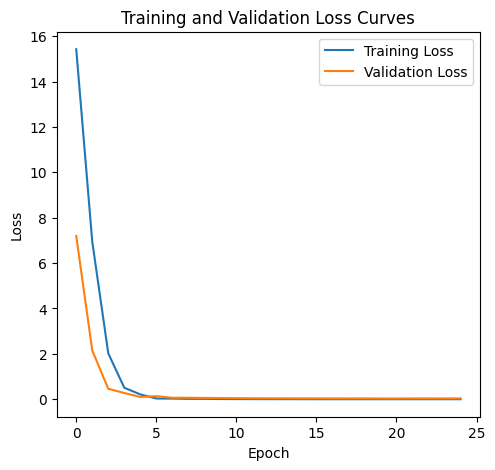

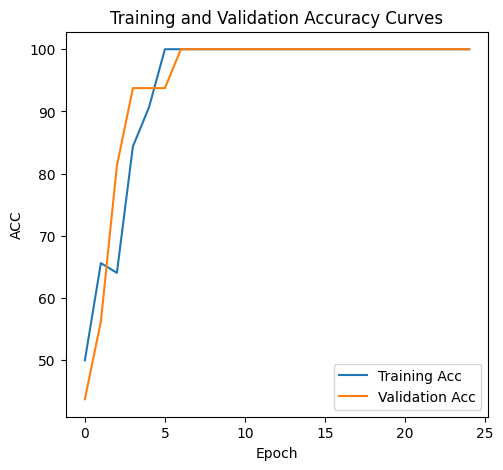

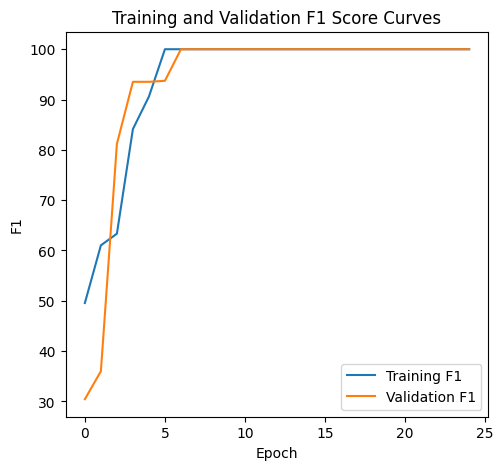

In [20]:
def main():

    seed_everything(config.seed)
    
    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    print("Initializing dataset...")  
    train_df = df.iloc[train_ids]
    valid_df = df.iloc[valid_ids]
    train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
    valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

    
    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_late = Late_fusion(num_classes = num_classes, features_grad = True)
    model_late.to(config.device)

    # 散則適當的criterion, optimizer
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model_late.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    # 以 epoch 為單位來更新學習率
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_late, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model_late.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Late.pth")

        best_ckpt = torch.load("checkpoint_Late.pth", map_location=config.device)
        model_late.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model_late, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_loader
    del valid_loader
    del train_dataset
    del valid_dataset
    gc.collect()
    # 用於釋放 CUDA GPU 的顯存
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

In [21]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))

test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model_late = Late_fusion(num_classes = 2, features_grad = True)

model_late.to("cuda")

best_ckpt = torch.load(f"checkpoint_Late.pth")
model_late.load_state_dict(best_ckpt["model"])

preds = testing(model_late, test_loader, config.device)
del test_dataset
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:41<00:00,  1.05s/it]


In [22]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("late.csv", index=False)

## Single Slice

In [23]:
class config:
    
    root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
    valid_prob = 0.2
    batch_size = 4
    lr = 5e-4
    epochs = 25
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


### Single slice model

In [24]:
# 建立完整的 Single slice model
class Single_slice(nn.Module):
    def __init__(self, num_classes, input_size=(3, 50, 50), features_grad=False): 
        super().__init__()
        
        # 取出vgg16中的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        vgg16.classifier = nn.Identity()
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
        self.backend = vgg16
        
        # 修改分類層
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)
        
        self.softmax = nn.Softmax(dim=1)
    
    # 定義 forward 函數
    def forward(self, x):  # x: 22 個 (batch_size, 3, 256, 256) 的 list
        
        # 用於存儲每個切片的 softmax 結果
        softmax_outputs = []
        
        # Step1: 對 x[i] 提取特徵得到 feature map
        for i in range(len(x)):
            feature_map = self.backend(x[i])  # shape: (batch_size, 512, 7, 7)
            feature_map = feature_map.view(feature_map.size(0), -1)  # shape: (batch_size, 512 * 7 * 7)
            
            # Step2: 將 feature map 通過 classifier 和 softmax
            class_output = self.classifier(feature_map)  # shape: (batch_size, num_classes)
            softmax_output = self.softmax(class_output)  # shape: (batch_size, num_classes)
            softmax_outputs.append(softmax_output)
        
        # Step3: 將 22 個 softmax 結果進行平均得到 output
        output = torch.mean(torch.stack(softmax_outputs, dim=0), dim=0)  # shape: (batch_size, num_classes)
        
        # Step4: 將 output 取 log 並輸出成 log_output
        log_output = torch.log(output + 1e-10)  # 避免 log(0)
        
        return log_output

如何完成 Single_slice 的 forward function，請透過下方的步驟：

- Step1: 對 x[i] 提取特徵得到 feature map

- Step2: 將 22 張 feature map 各自通過 classifier 並作 softmax

- Step3: 將 22 個 softmax 完的結果進行進行平均得到 output

- Step4: 將 Step3 得到的結果取 log 並輸出成 log_output，讓後續 nn.NLLLoss() 運行正常

**Hint of Step1,2,3: 用一個迴圈完成**

**Hint of Step4: `log_output = torch.log(output + 1e-10)`，為了避免出現 log(0) 的情況**

### Parameters of Single slice model

In [25]:
model_single = Single_slice(num_classes = 2)
print(model_single)
total_params = sum(p.numel() for p in model_single.parameters())
print("總參數量:", total_params)

Single_slice(
  (backend): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
     

In [26]:
# 隨機生成一個 batch size 為 4 、切片大小為（3, 256, 256）的 3D image
x = [torch.randn(4,3,256,256) for _ in range(22)] # x: [(4,3,256,256),...,(4,3,256,256)]
output = model_single(x)
print(output, output.shape)
# 如果輸出一個大小為 torch.Size([4,2]) 的張量，表示測試通過
del model_single
gc.collect()

tensor([[-0.7669, -0.6245],
        [-0.7745, -0.6180],
        [-0.7703, -0.6215],
        [-0.7527, -0.6369]], grad_fn=<LogBackward0>) torch.Size([4, 2])


8

### Single slice main

**過去使用`nn.CrossEntropyLoss()`是將模型輸出的 logits 進行 Softmax 再轉成 log 的形式再計算損失函數。Single slice model 是將 22 個結果進行平均，但如果對 logits 平均會有點不合理，因此我們在 model 的階段使用 `nn.Softmax` 來將 logits 變成機率的形式，再將平均的機率取 log，所以後續使用的 criterion 要改成使用 `nn.NLLLoss()` 計算損失。**

`nn.CrossEntropyLoss() 相當於 Softmax - Log - NLLLoss()`


Initializing dataset...


100%|██████████| 16/16 [00:06<00:00,  2.40it/s]


Initializing model...
num_classes 2
Start training!
Epoch[1/25], Train Loss: 1.0552, Train Accuracy: 65.62%, Train F1: 65.59% | Valid Loss: 0.5941, Valid Accuracy: 50.00%, Valid F1: 41.82% | LR: 0.000020
Epoch[2/25], Train Loss: 0.7293, Train Accuracy: 65.62%, Train F1: 63.90% | Valid Loss: 0.4293, Valid Accuracy: 81.25%, Valid F1: 79.22% | LR: 0.000020
Epoch[3/25], Train Loss: 0.5783, Train Accuracy: 67.19%, Train F1: 63.23% | Valid Loss: 0.5113, Valid Accuracy: 62.50%, Valid F1: 60.00% | LR: 0.000021
Epoch[4/25], Train Loss: 0.5441, Train Accuracy: 78.12%, Train F1: 77.78% | Valid Loss: 0.3804, Valid Accuracy: 81.25%, Valid F1: 79.22% | LR: 0.000021
Epoch[5/25], Train Loss: 0.4383, Train Accuracy: 85.94%, Train F1: 85.93% | Valid Loss: 0.3599, Valid Accuracy: 93.75%, Valid F1: 93.52% | LR: 0.000022
Epoch[6/25], Train Loss: 0.3790, Train Accuracy: 90.62%, Train F1: 90.62% | Valid Loss: 0.3079, Valid Accuracy: 100.00%, Valid F1: 100.00% | LR: 0.000023
Epoch[7/25], Train Loss: 0.3090, T

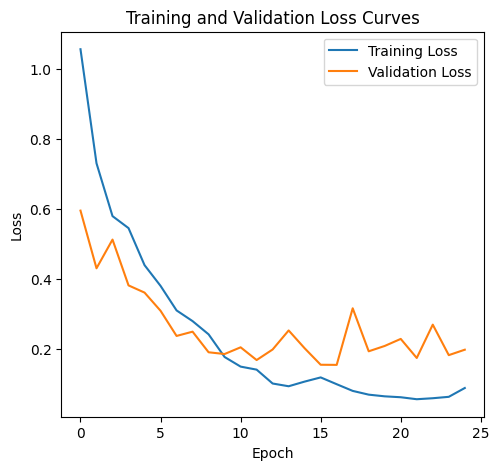

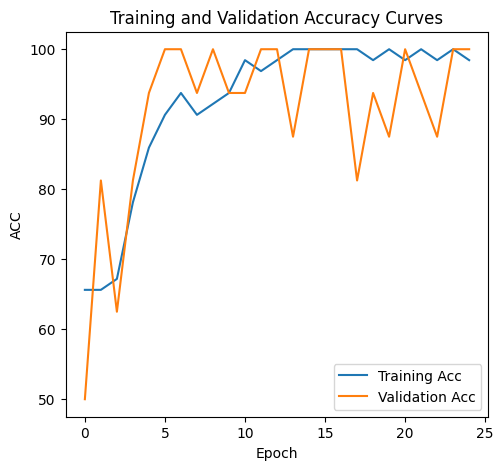

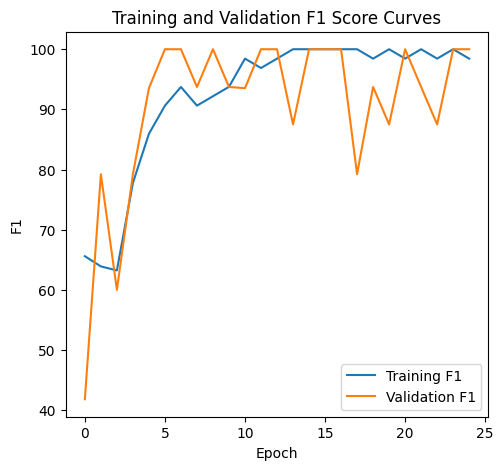

In [27]:
# nn.CrossEntropyLoss() 改成 nn.NLLLoss()
def main():
    seed_everything(config.seed)
    
    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    print("Initializing dataset...")  
    train_df = df.iloc[train_ids]
    valid_df = df.iloc[valid_ids]
    train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
    valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

    
    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_single = Single_slice(num_classes=num_classes, features_grad=True)
    model_single.to(config.device)

    # 散則適當的criterion, optimizer
    criterion = nn.NLLLoss().to(config.device)
    optimizer = torch.optim.Adam(model_single.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    # 以 epoch 為單位來更新學習率
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_single, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation( model_single, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model_single.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Single.pth")

        best_ckpt = torch.load("checkpoint_Single.pth", map_location=config.device)
        model_single.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model_single, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_loader
    del valid_loader
    del train_dataset
    del valid_dataset
    gc.collect()
    # 用於釋放 CUDA GPU 的顯存
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    

if __name__ == "__main__":
    main()

In [28]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))

test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model_single = Single_slice(num_classes=2, features_grad=True)

model_single.to("cuda")

best_ckpt = torch.load(f"checkpoint_Single.pth")
model_single.load_state_dict(best_ckpt["model"])

preds = testing(model_single, test_loader, config.device)
del test_dataset
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:15<00:00,  2.55it/s]


In [29]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("single.csv", index=False)

## Early Fusion

In [30]:
class config:
    
    root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
    valid_prob = 0.2
    batch_size = 4
    lr = 5e-4
    epochs = 25
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


### Early fusion model

In [31]:
# class Early_fusion(nn.Module):
#     def __init__(self, num_classes, input_size=(3, 256, 256), features_grad=False):
#         super().__init__()

#         # 取出 VGG16 的特徵層
#         vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        
#         # 將 VGG16 的 classifier 層替換為 nn.Identity()，丟棄預設的分類層
#         vgg16.classifier = nn.Identity()

#         # 固定/不固定特徵層的參數值
#         for param in vgg16.features.parameters():
#             param.requires_grad = features_grad

#         # 載入 VGG16 作為特徵提取 backbone
#         self.backend = vgg16
        
#         # 增加分類層
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 7 * 7, num_classes)
#         )

#     def forward(self, x):  # x: 22 個 (batch_size, 3, 256, 256) 的 list
        
#         # 在 Early Fusion 中，我們先對所有影像進行平均，再將結果送入 VGG16 提取特徵
#         # 將 22 張影像在維度 0 進行平均，使其成為 (batch_size, 3, 256, 256)
#         x_fused = torch.stack(x, dim=0).mean(dim=0)  # shape: (batch_size, 3, 256, 256)
        
#         # 將融合後的影像通過 VGG16 提取特徵
#         feature_map = self.backend(x_fused)  # shape: (batch_size, 512, 7, 7)
#         feature_map_flat = feature_map.view(feature_map.size(0), -1)  # shape: (batch_size, 512 * 7 * 7)

#         # 通過分類層進行分類
#         outputs = self.classifier(feature_map_flat)

#         return outputs

In [32]:
class Early_fusion(nn.Module):
    def __init__(self, num_classes, input_size=(66, 256, 256), T=22, features_grad=False):
        super(Early_fusion, self).__init__()
        
        # 取出 VGG16 的特徵層
        vgg16 = models.vgg16(weights='IMAGENET1K_V1', progress=True)
        vgg16.features[0] = nn.Conv2d(66, 64, kernel_size=3, stride=1, padding=1)
        
        # 固定/不固定特徵層的參數值
        for param in vgg16.features.parameters():
            param.requires_grad = features_grad
            
        
        # 使用標準的 VGG16 網路，丟棄預設的分類層
        vgg16.classifier = nn.Identity()
        
        # 取出 VGG16 的後續層作為 backend
        self.backend = nn.Sequential(
            vgg16.features,
            vgg16.avgpool
        )
        
        # 定義分類層
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, num_classes)
        )
        
    def forward(self, x):  # x 是一個包含 22 張影像的 list，每張影像大小為 (8, 3, 256, 256)
        # 將輸入的 22 張影像在 channel 維度上進行拼接
        x = torch.cat(x, dim=1)  # 拼接後 x 的 shape: (8, 3 * 22, 256, 256)
        
        # 將卷積結果輸入到 VGG16 backend 中
        x = self.backend(x)  # shape: (8, 512, 7, 7)
        
        # 攤平並輸入到分類層
        x = x.view(x.size(0), -1)  # shape: (8, 512 * 7 * 7)
        x = self.classifier(x)     # shape: (8, num_classes)
        
        return x

### Parameters of Early fusion model

In [33]:
model_early = Early_fusion(num_classes = 2)
print(model_early)
total_params = sum(p.numel() for p in model_early.parameters())
print("總參數量:", total_params)

Early_fusion(
  (backend): Sequential(
    (0): Sequential(
      (0): Conv2d(66, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [34]:
# 隨機生成一個 batch size 為 4 、切片大小為（3, 256, 256）的 3D image
x = [torch.randn(4,3,256,256) for _ in range(22)] # x: [(4,3,256,256),...,(4,3,256,256)]
output = model_early(x)
print(output, output.shape)
# 如果輸出一個大小為 torch.Size([4,2]) 的張量，表示測試通過
del model_early
gc.collect()

tensor([[-0.0383, -0.0052],
        [-0.0348,  0.0012],
        [-0.0443, -0.0251],
        [-0.0440, -0.0057]], grad_fn=<AddmmBackward0>) torch.Size([4, 2])


9

### Early fusion main

Initializing dataset...


100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Initializing model...
num_classes 2
Start training!
Epoch[1/25], Train Loss: 1.0570, Train Accuracy: 54.69%, Train F1: 54.68% | Valid Loss: 0.9950, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000020
Epoch[2/25], Train Loss: 0.5154, Train Accuracy: 73.44%, Train F1: 73.27% | Valid Loss: 0.6706, Valid Accuracy: 68.75%, Valid F1: 61.35% | LR: 0.000020
Epoch[3/25], Train Loss: 0.2268, Train Accuracy: 90.62%, Train F1: 90.54% | Valid Loss: 0.5661, Valid Accuracy: 68.75%, Valid F1: 67.61% | LR: 0.000021
Epoch[4/25], Train Loss: 0.1008, Train Accuracy: 100.00%, Train F1: 100.00% | Valid Loss: 0.6095, Valid Accuracy: 75.00%, Valid F1: 70.91% | LR: 0.000021
Epoch[5/25], Train Loss: 0.0861, Train Accuracy: 100.00%, Train F1: 100.00% | Valid Loss: 0.5764, Valid Accuracy: 68.75%, Valid F1: 65.37% | LR: 0.000022
Epoch[6/25], Train Loss: 0.0776, Train Accuracy: 100.00%, Train F1: 100.00% | Valid Loss: 0.6256, Valid Accuracy: 75.00%, Valid F1: 70.91% | LR: 0.000023
Epoch[7/25], Train Loss: 0.087

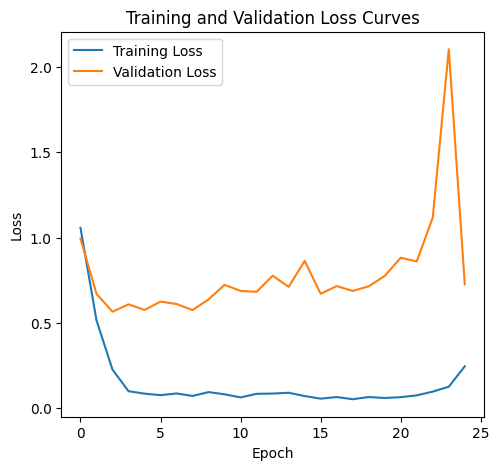

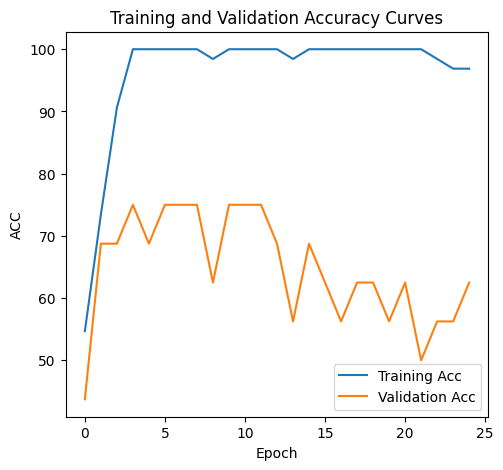

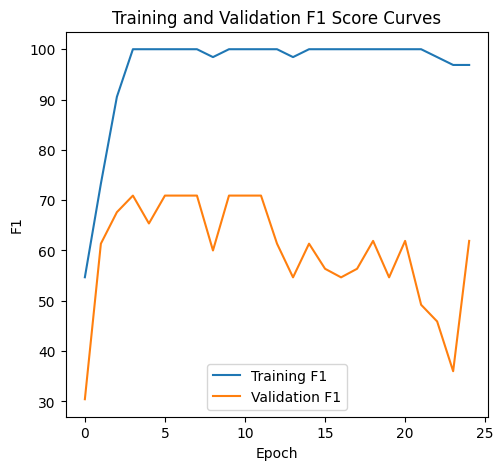

In [35]:
def main():
    
    seed_everything(config.seed)
    
    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    print("Initializing dataset...")  
    train_df = df.iloc[train_ids]
    valid_df = df.iloc[valid_ids]
    train_dataset = MRI2DDataset(train_df, mode = "train",transforms = build_transform(True))
    valid_dataset = MRI2DDataset(valid_df, mode = "valid",transforms = build_transform(False))

    
    # DataLoader
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)
    
    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model_early = Early_fusion(num_classes = num_classes, features_grad = True)
    model_early.to(config.device)

    # 散則適當的criterion, optimizer
    criterion = nn.CrossEntropyLoss().to(config.device)
    optimizer = torch.optim.Adam(model_early.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    # 以 epoch 為單位來更新學習率
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)
    # 以 batch 為單位來更新學習率
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    print("Start training!")
    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model_early, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model_early, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model_early.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_Early.pth")

        best_ckpt = torch.load("checkpoint_Early.pth", map_location=config.device)
        model_early.load_state_dict(best_ckpt["model"])
    
    valid_loss, valid_acc, valid_f1 = validation(model_early, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_loader
    del valid_loader
    del train_dataset
    del valid_dataset
    gc.collect()
    # 用於釋放 CUDA GPU 的顯存
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('ACC')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('F1')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()
    

if __name__ == "__main__":
    main()

In [36]:
seed_everything(config.seed)
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))

test_dataset = MRI2DDataset(test_df, mode = "test",transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)
model_early = Early_fusion(num_classes = 2, features_grad = True)

model_early.to("cuda")

best_ckpt = torch.load(f"checkpoint_Early.pth")
model_early.load_state_dict(best_ckpt["model"])

preds = testing(model_early, test_loader, config.device)
del test_dataset
gc.collect()
torch.cuda.empty_cache()

100%|██████████| 40/40 [00:15<00:00,  2.57it/s]


In [37]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("early.csv", index=False)

# 3D CNN

## 3D Dataset

In [38]:
class config:

    root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
    valid_prob = 0.2
    batch_size = 4
    lr = 1e-4
    epochs = 10
    weight_decay = 1e-3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    seed = 42
    
print(config.device)

cuda


In [39]:
class MRI3DDataset(torch.utils.data.Dataset):
    def __init__(self, df, mode = None, transforms = None):
        
        root = "/kaggle/input/deeplearninghw3-2/hwk03_data"
        self.ids = np.array(df["ID"])
        self.labels = torch.tensor(df["Disease"].values) 
        self.mode = mode
        self.transforms = transforms
        
        paths = []
        for ID in self.ids:
            path = os.path.join(root, "DICOM", str(ID).split('.')[0].zfill(7))
            paths.append(path)
        
        self.images = []
        
        for path in tqdm(paths):
            all_slices = []
            T1_root = os.path.join(root, "DICOM", path, "T1")
            T2_root = os.path.join(root, "DICOM", path, "T2")
            for filename in sorted(os.listdir(T1_root), key = lambda s: int(pydicom.dcmread(os.path.join(T1_root, s)).InstanceNumber)):
                T1_image = []
                T2_image = []
                
                # T1 images
                img = pydicom.dcmread(os.path.join(T1_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T1_image.append(img) 
                
                # T2 images
                img = pydicom.dcmread(os.path.join(T2_root, filename))
                ww = img.WindowWidth
                wc = img.WindowCenter
                highest_visible_value = (ww + 2 * wc) / 2
                lowest_visible_value = highest_visible_value - ww
                
                img = img.pixel_array
                img = np.clip(img, lowest_visible_value, highest_visible_value)
                img = 255 * (img - lowest_visible_value) / ww
                img = cv2.resize(img, (256, 256))
                
                T2_image.append(img)
                
                # T1T2 images
                T1T2_image = (T1_image[0] + T2_image[0]) / 2
                T1T2_image = torch.tensor(T1T2_image)
                
                T1_image = torch.tensor(T1_image[0])
                T2_image = torch.tensor(T2_image[0])
                
                all_slices.append(torch.stack((T1_image, T2_image, T1T2_image), dim = 0)) 
                # 其中 torch.stack((T1_image, T2_image, T1T2_image), dim = 0) 的形狀是 (3, 512, 512)
            
            slices = torch.stack(all_slices, dim = 1) # (3, XX, 512, 512) XX為原始切片數量
            
            if self.transforms:
                slices = self.transforms(slices) # (22, 3, 256, 256)
                slices = torch.transpose(slices, 0, 1) # (3, 22, 256, 256)
            
            self.images.append(slices.float())
    
    def __getitem__(self, index):
        
        if self.mode == "train":
            
            images = self.images[index]
            label = self.labels[index]    
            
            return images, label
        
        elif self.mode == "valid":
            
            images = self.images[index]
            label = self.labels[index]
            
            return images, label
        
        elif self.mode == "test":
            
            images = self.images[index]
            
            return images
    
    def __len__(self):
        return(len(self.ids))

In [40]:
train_df = pd.read_csv(os.path.join(config.root,"train.csv"))
print("Initializing dataset...")
dataset = MRI3DDataset(train_df, mode = "train", transforms = build_transform(True))

print(dataset[0][0].shape)
del dataset
gc.collect()

Initializing dataset...


100%|██████████| 80/80 [00:32<00:00,  2.50it/s]

torch.Size([3, 22, 256, 256])


0

## 3D CNN model

[MedicalNet](https://github.com/Tencent/MedicalNet/tree/master)

[pretrained.pth](https://www.kaggle.com/datasets/werus23/medicalnet)

In [41]:
# 載入github資源
!git clone https://github.com/Tencent/MedicalNet.git
import sys
sys.path.append('/kaggle/input/medicalnet/MedicalNet/MedicalNet')
from models import resnet

Cloning into 'MedicalNet'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 120 (delta 50), reused 43 (delta 43), pack-reused 51 (from 1)
Receiving objects: 100% (120/120), 47.63 MiB | 18.52 MiB/s, done.
Resolving deltas: 100% (50/50), done.


In [42]:
# 層數可自行決定
def generate_model(model_type='resnet', model_depth=50,
                   input_W=224, input_H=224, input_D=224, shortcut_type='B',
                   no_cuda=True, gpu_id=[0],
                   pretrain_path = 'pretrain/resnet_50.pth',
                   nb_class=1):

    # shortcut_type = "B"在 ResNet 中指的是一種捷徑（shortcut）連接方法，用來讓輸入和輸出尺寸一致。
    
    # 因為我們是調用上面 github 提供的模型，因為只有提供 resnet 所以這邊確認 model_type 是 resnet
    assert model_type in [
        'resnet'
    ]
    # 當 model_type 確認為 resnet 時，再檢查 model_depth 是否在指定的範圍內（10、18、34、50、101、152、200）
    if model_type == 'resnet':
        assert model_depth in [10, 18, 34, 50, 101, 152, 200]

    model = resnet.resnet50(sample_input_W=input_W, sample_input_H=input_H, sample_input_D=input_D, num_seg_classes = nb_class)

    # 修改原本的 conv_seg 模組來應用到我們的分類任務
    model.conv_seg = nn.Sequential(nn.AdaptiveAvgPool3d((1, 1, 1)), nn.Flatten())
    # nn.AdaptiveAvgPool3d((1, 1, 1))：這層會將輸入的 feature map 進行 Global Average Pooling，將維度 (D, H, W) 縮小到 (1, 1, 1)。最終輸出會是形狀 (batchsize, channels, 1, 1, 1)
    # nn.Flatten()：將 pooling 後的輸出攤成一個二維向量，形狀是 (batchsize, channels)
    
    
    if not no_cuda:
        if len(gpu_id) > 1:
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=gpu_id)
            net_dict = model.state_dict()
        else:
            import os
            os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu_id[0])
            model = model.cuda()
            model = nn.DataParallel(model, device_ids=None)
            net_dict = model.state_dict()
    else:
        net_dict = model.state_dict()

    print('loading pretrained model {}'.format(pretrain_path))
    pretrain = torch.load(pretrain_path)
    pretrain_dict = {k: v for k, v in pretrain['state_dict'].items() if k in net_dict.keys()}

    net_dict.update(pretrain_dict)

    return model

In [43]:
resnet50_3d = generate_model(model_type='resnet', model_depth=50,
                 input_W=256, input_H=256, input_D=22, shortcut_type='B',
                 pretrain_path = "/kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth",
                 nb_class=2)

resnet50_3d.classifier = nn.Identity()
print(resnet50_3d)

loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth
ResNet(
  (conv1): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=(3, 3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv3d(64, 64, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
      (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv3d(64, 256, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
      (bn3): BatchNorm3d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [44]:
class Resnet3d(nn.Module):
    def __init__(self, num_classes, features_grad = False):
        super().__init__()

         # 用上方定義 generate_model 函數生成一個預訓練的 3D ResNet50 模型。
        resnet50_3d = generate_model(model_type='resnet', model_depth=50,
                         input_W=256, input_H=256, input_D=22, shortcut_type='B',
                         pretrain_path = "/kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth",
                         nb_class=2)

        resnet50_3d.classifier = nn.Identity()

        for param in resnet50_3d.parameters():
            param.requires_grad = features_grad 
            
        # 更改成 3 channel
        temp = [param for param in resnet50_3d.conv1.parameters()][0] # (64, 1, 7, 7, 7)
        temp = torch.cat((temp, temp, temp), dim = 1) # (64, 3, 7, 7, 7)
        resnet50_3d.conv1 = nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
        for param in resnet50_3d.conv1.parameters():
            param = temp

        self.backend = resnet50_3d
        self.classifier = nn.Sequential(
          nn.Linear(2048, num_classes)
        )

    def forward(self, x): # x 是一個 (batchsize, 3, 22, 256, 256) 的 tensor
        if type(x) == list:
            x = torch.stack(x, dim=0)
        output = self.backend(x)
        outputs = self.classifier(output)
        return outputs

In [45]:
model_3d = Resnet3d(num_classes = 2)
total_params = sum(p.numel() for p in model_3d.parameters())
print("總參數量:", total_params)

loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth
總參數量: 46203074


In [46]:
model_3d = Resnet3d(num_classes = 2)
model_3d.to("cuda")

# 隨機一個 (batchsize=4, 3, 22, 256, 256) 的 tensor
x = torch.randn((4, 3, 22, 256, 256)).to("cuda")
output = model_3d(x)
print(output)

del model_3d, x
gc.collect()
torch.cuda.empty_cache()

loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth
tensor([[ 0.3172, -0.0800],
        [ 0.3118, -0.0551],
        [ 0.3250, -0.0788],
        [ 0.3018, -0.0673]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [47]:
model = Resnet3d(num_classes = 2)
model.to("cuda")
summary(model, input_size = (3, 22, 256, 256))

loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 64, 11, 128, 128]          65,856
       BatchNorm3d-2     [-1, 64, 11, 128, 128]             128
              ReLU-3     [-1, 64, 11, 128, 128]               0
         MaxPool3d-4        [-1, 64, 6, 64, 64]               0
            Conv3d-5        [-1, 64, 6, 64, 64]           4,096
       BatchNorm3d-6        [-1, 64, 6, 64, 64]             128
              ReLU-7        [-1, 64, 6, 64, 64]               0
            Conv3d-8        [-1, 64, 6, 64, 64]         110,592
       BatchNorm3d-9        [-1, 64, 6, 64, 64]             128
             ReLU-10        [-1, 64, 6, 64, 64]               0
           Conv3d-11       [-1, 256, 6, 64, 64]          16,384
      BatchNorm3d-12       [-1, 256, 6, 64, 64]             512
           Conv3d

100%|██████████| 16/16 [00:06<00:00,  2.33it/s]


Initializing model...
num_classes 2
loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth
Epoch[1/10], Train Loss: 0.7251, Train Accuracy: 51.56%, Train F1: 34.02% | Valid Loss: 0.7391, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000004
Epoch[2/10], Train Loss: 0.7113, Train Accuracy: 51.56%, Train F1: 34.02% | Valid Loss: 0.7323, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000004
Epoch[3/10], Train Loss: 0.7024, Train Accuracy: 51.56%, Train F1: 34.02% | Valid Loss: 0.7196, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000005
Epoch[4/10], Train Loss: 0.6981, Train Accuracy: 51.56%, Train F1: 34.02% | Valid Loss: 0.7106, Valid Accuracy: 43.75%, Valid F1: 30.43% | LR: 0.000006
Epoch[5/10], Train Loss: 0.6905, Train Accuracy: 51.56%, Train F1: 34.02% | Valid Loss: 0.7053, Valid Accuracy: 43.75%, Valid F1: 41.70% | LR: 0.000007
Epoch[6/10], Train Loss: 0.6977, Train Accuracy: 50.00%, Train F1: 40.12% | Valid Loss: 0.6990, Valid Accuracy: 43.75%

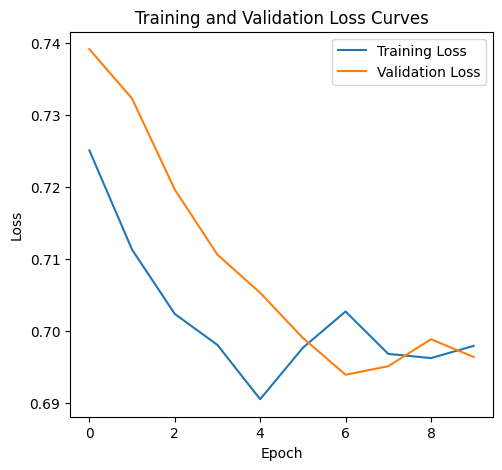

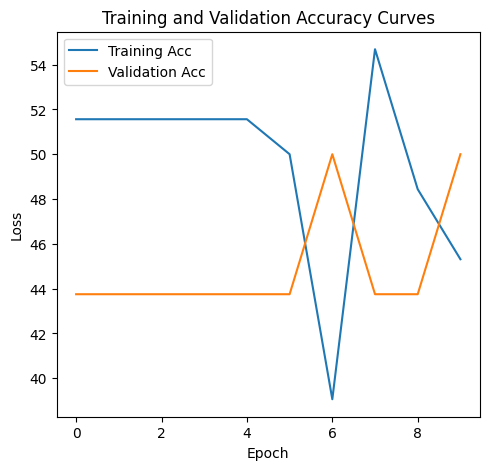

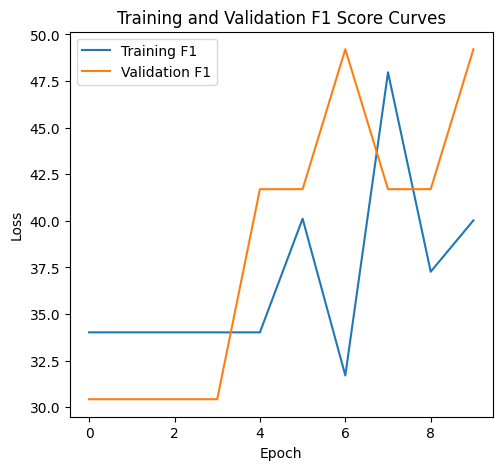

In [48]:
def main():

    seed_everything(config.seed)

    df = pd.read_csv(os.path.join(config.root, "train.csv"))
    
    # split training & validation dataset 
    n = df.shape[0]
    valid_size = int(n * config.valid_prob)
    train_ids , valid_ids = train_test_split(
     np.linspace(0, n - 1, n).astype("int"),
     test_size = valid_size,
     random_state = config.seed,
    )
    
    # DataLoader
    train_data = df.iloc[train_ids]
    valid_data = df.iloc[valid_ids]
    train_dataset = MRI3DDataset(train_data, mode = "train", transforms = build_transform(True))
    valid_dataset = MRI3DDataset(valid_data, mode = "valid", transforms = build_transform(False))
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=config.batch_size, shuffle=False)

    
    # settings
    print("Initializing model...")
    num_classes = 2
    print('num_classes',num_classes)
    model = Resnet3d(num_classes = num_classes, features_grad = False)
    model.to(config.device)
    criterion = nn.CrossEntropyLoss().to(config.device)

    # 選擇適當的 optimizer, scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr = config.lr, weight_decay = config.weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer = optimizer,
        epochs = config.epochs,
        steps_per_epoch = train_loader.__len__(),
        max_lr = config.lr,
        anneal_strategy = 'cos'
    )

    # recordings
    best_val_loss = float("inf")
    history = {
      "train": {
          "loss": [],
          "acc": [],
          "f1": []
      },
      "valid": {
          "loss": [],
          "acc": [],
          "f1": []
      },
    }

    for epoch in range(config.epochs):
        train_loss, train_acc, train_f1 = train_one_epoch(model, train_loader, optimizer, scheduler, criterion, config.device)
        valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)

        # Log the loss and validation result
        history["train"]["loss"].append(train_loss)
        history["train"]["acc"].append(train_acc)
        history["train"]["f1"].append(train_f1)
        history["valid"]["loss"].append(valid_loss)
        history["valid"]["acc"].append(valid_acc)
        history["valid"]["f1"].append(valid_f1)

        print(f'Epoch[{epoch+1}/{config.epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Train F1: {train_f1:.2f}% | Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}% | LR: {optimizer.state_dict()["param_groups"][0]["lr"]:.6f}')

        if valid_loss < best_val_loss:
            save_file = {
                "model": model.state_dict(),
                "optimizer": optimizer.state_dict(),
                "scheduler": scheduler.state_dict(),
                "epoch": epoch,
                "args": config
            }
            best_val_loss = valid_loss
            torch.save(save_file, "checkpoint_3D.pth")

        best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
        model.load_state_dict(best_ckpt["model"])

    valid_loss, valid_acc, valid_f1 = validation(model, valid_loader, criterion, config.device)
    print("*"*10, " Validation ", "*"*10)
    print(f"Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_acc:.2f}%, Valid F1: {valid_f1:.2f}%")
    
    del train_dataset
    del valid_dataset
    del train_loader
    del valid_loader
    gc.collect()
    torch.cuda.empty_cache()
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["loss"], label='Training Loss')
    plt.plot(range(config.epochs), history["valid"]["loss"], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["acc"], label='Training Acc')
    plt.plot(range(config.epochs), history["valid"]["acc"], label='Validation Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Accuracy Curves')
    plt.show()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(config.epochs), history["train"]["f1"], label='Training F1')
    plt.plot(range(config.epochs), history["valid"]["f1"], label='Validation F1')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation F1 Score Curves')
    plt.show()

if __name__ == "__main__":
    main()

In [49]:
test_df = pd.read_csv(os.path.join(config.root, "test.csv"))
test_dataset = MRI3DDataset(test_df, mode = "test", transforms = build_transform(False))
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

model = Resnet3d(num_classes = 2).to("cuda")

best_ckpt = torch.load("checkpoint_3D.pth", map_location=config.device)
model.load_state_dict(best_ckpt["model"])

preds = testing(model, test_loader, config.device)

100%|██████████| 40/40 [00:14<00:00,  2.71it/s]


loading pretrained model /kaggle/input/medicalnet/Pretrained/Pretrained/resnet_50.pth


In [50]:
results_df = pd.read_csv(os.path.join(config.root, "submission.csv"))
results_df['Disease'] = preds.cpu().numpy() 
results_df.to_csv("3D.csv", index=False)